In [1]:
import os
from utils import load_raw_images, get_rgb_values, select_reference_image, load_ground_truth_reference_image, demo_images, folder_names
from align import naive_align
from align_and_merge import align_and_merge_channel
import matplotlib.pyplot as plt
import cv2

### First Figure

In [2]:
image_name = "c1b1_20150226_144326_422"
# image_name = "0127_20161107_171749_524"
# image_name = "33TJ_20150607_135208_428"
# image_name = "0543_20150918_143723_450"
folder_path = folder_names(image_name)[0]
dng_files_path = ['{}/{}'.format(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".dng")]
raw_images = load_raw_images(dng_files_path)

In [3]:
ref_image_index = select_reference_image(raw_images)

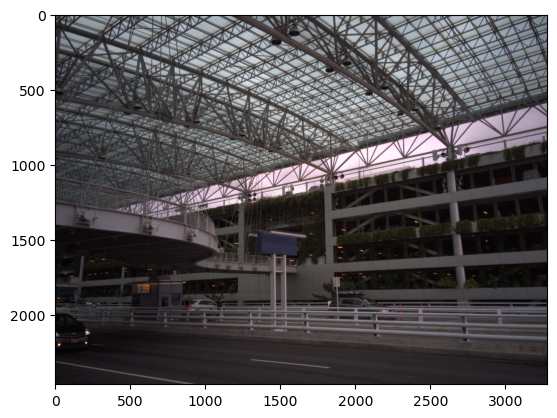

In [4]:
image_from_one_ref = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=raw_images[ref_image_index], no_auto_bright=False, use_camera_wb=True)
plt.imshow(image_from_one_ref)

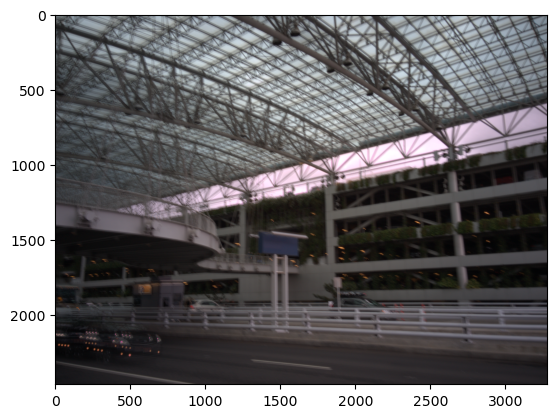

In [5]:
naive_aligned_image = naive_align(raw_images)
naive_aligned_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=naive_aligned_image, no_auto_bright=False, use_camera_wb=True)
plt.imshow(naive_aligned_rgb)

In [6]:
hdr_image = align_and_merge_channel(raw_images, ref_image_index)

downsampled raw images with shape:  (1232, 1640) previous shape:  (2464, 3280)
pyramid shapes:  [(19, 25), (77, 102), (308, 410), (1232, 1640)]


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


(10, 2464, 3280, 3) (10, 2464, 3280)


100%|██████████| 154/154 [00:17<00:00,  8.88it/s]


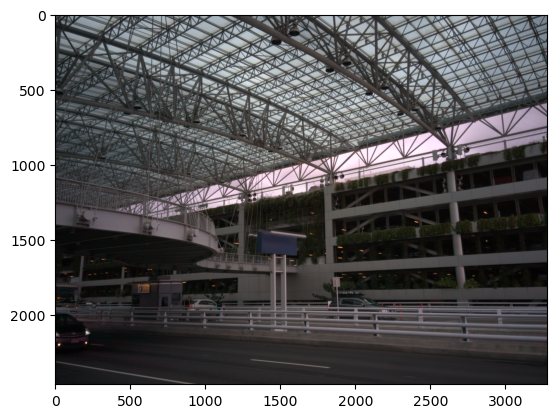

In [7]:
hdr_aligned_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=hdr_image, no_auto_bright=False, use_camera_wb=True)
plt.imshow(hdr_aligned_rgb)

C:\Users\macvi\AppData\Local\Temp\ipykernel_33700\1867668445.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


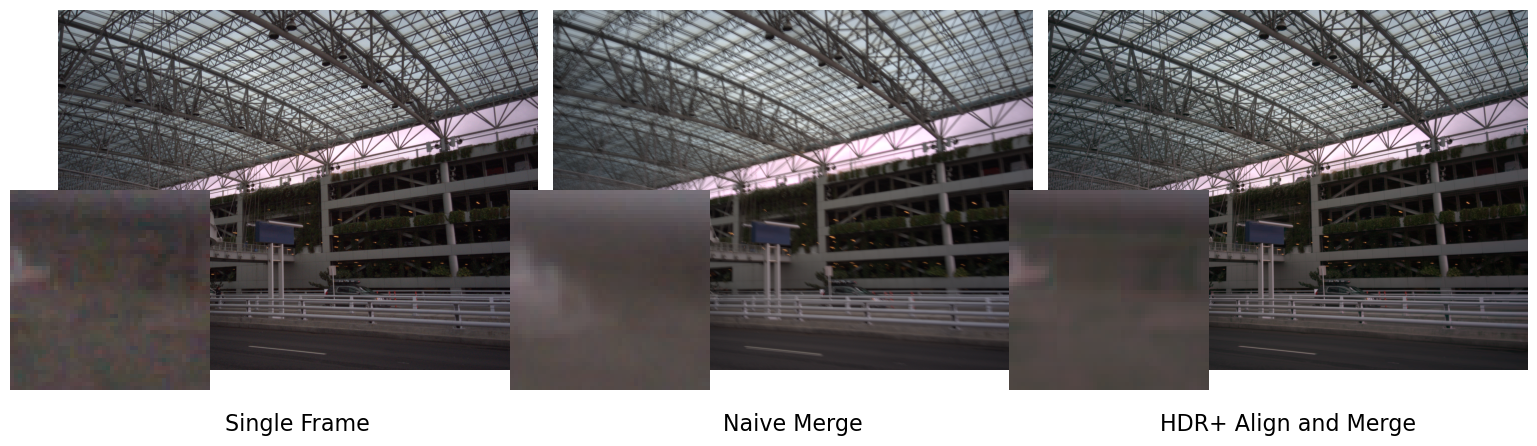

In [8]:
def create_figure(images, output_path, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Coordinates for the zoom-in boxes
    zoom_coords = [
        (1700, 2100, 1750, 2150),
        (1700, 2100, 1750, 2150),
        (1700, 2100, 1750, 2150),
    ]

    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')

        # Add the zoom-in box
        left, top, right, bottom = zoom_coords[i]
        inset_ax = fig.add_axes([-0.08 + i * 0.333, 0.1, 0.25, 0.4])
        img_crop = img[top:bottom, left:right]
        inset_ax.imshow(img_crop)
        inset_ax.axis('off')
        
        axs[i].text(0.5, -0.15, labels[i], ha='center', va='center', transform=axs[i].transAxes, fontsize=16)

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
image_lables = ['Single Frame', 'Naive Merge', 'HDR+ Align and Merge']
create_figure([image_from_one_ref, naive_aligned_rgb, hdr_aligned_rgb], './paper_illustrations/title_image.png', image_lables)

## Motion Vectors Align

In [9]:
from utils import upsample_image
from align import burst_align, align, upsample_image, gaussian_downsample
from merge import merge_images, merge_patches
import numpy as np

In [10]:
def get_motion_matrix(raw_images, ref_image_index):
    # A coarse-to-fine, pyramid-based block matching that creates a pyramid representation of every input frame and performs a limited window search to find the most similar tile

    # Downsample the raw images to speed up alignment
    downsampled_raw_images = np.array([gaussian_downsample(raw_image, 2) for raw_image in raw_images])
    print("downsampled raw images with shape: ", downsampled_raw_images[0].shape, "previous shape: ", raw_images[0].shape)

    # Generate alignment matrix using pyramid block matching
    motion_matrix = burst_align(ref_image_index, downsampled_raw_images)

    # Upsample the motion matrix to the original image size
    motion_matrix = upsample_image(motion_matrix, raw_images.shape[1], raw_images.shape[2]) * 2
    
    return motion_matrix


In [11]:
motion_matrix = get_motion_matrix(raw_images, ref_image_index)

downsampled raw images with shape:  (1232, 1640) previous shape:  (2464, 3280)
pyramid shapes:  [(19, 25), (77, 102), (308, 410), (1232, 1640)]


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


In [12]:
motion_matrix.shape

(10, 2464, 3280, 3)

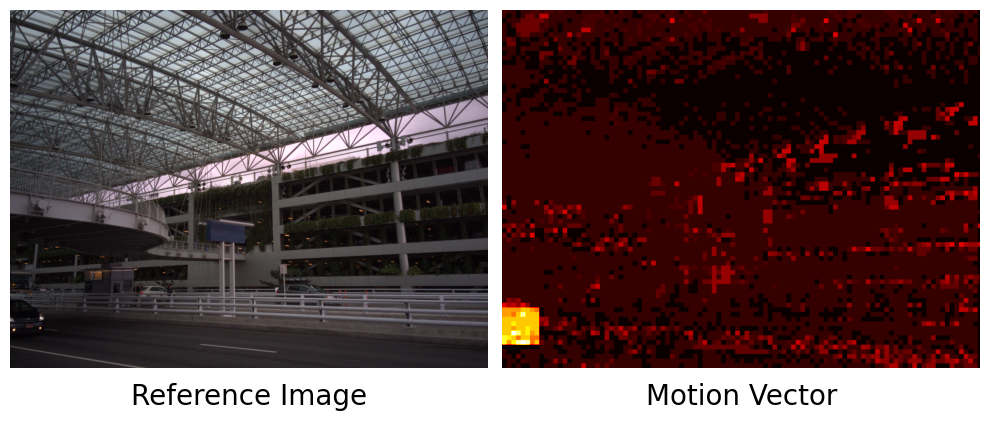

In [13]:
def create_motion_matrix_figure(images, output_path, labels):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Coordinates for the zoom-in boxes
    zoom_coords = [
        (1700, 2100, 1750, 2150),
        (1700, 2100, 1750, 2150),
        (1700, 2100, 1750, 2150),
    ]

    for i, img in enumerate(images):
        if i == 1:
            axs[i].imshow(np.linalg.norm(img[:, :, :2], axis=-1), cmap='hot')
        else:
            axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].text(0.5, -0.08, labels[i], ha='center', va='center', transform=axs[i].transAxes, fontsize=20)

        # Add the zoom-in box
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
image_lables = ['Reference Image', 'Motion Vector']
test_motion_matrix = motion_matrix[1].astype(np.float32)
create_motion_matrix_figure([image_from_one_ref, test_motion_matrix], './paper_illustrations/motion_vector.png', image_lables)

### Merging Image

In [14]:
aligned_burst_patches = align(motion_matrix, raw_images)
def get_merge_images(aligned_burst_patches, spatial_denoise=True, temporal_denoise=True, ref_image_index=0):
    final_merged_frame = merge_images(aligned_burst_patches, ref_image_index, temporal_denoise=temporal_denoise, spatial_denoise=spatial_denoise)
    final_merged_bayer = merge_patches(final_merged_frame)
    final_merged_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=final_merged_bayer, no_auto_bright=False, use_camera_wb=True)
    return final_merged_rgb

(10, 2464, 3280, 3) (10, 2464, 3280)


100%|██████████| 10/10 [00:00<00:00, 20.21it/s]


In [15]:
no_denoise_image = get_merge_images(aligned_burst_patches, spatial_denoise=False, temporal_denoise=False, ref_image_index=ref_image_index)
spatial_denoise_image = get_merge_images(aligned_burst_patches, spatial_denoise=True, temporal_denoise=False, ref_image_index=ref_image_index)
temporal_denoise_image = get_merge_images(aligned_burst_patches, spatial_denoise=False, temporal_denoise=True, ref_image_index=ref_image_index)
spatial_temporal_denoise_image = get_merge_images(aligned_burst_patches, spatial_denoise=True, temporal_denoise=True, ref_image_index=ref_image_index)

100%|██████████| 154/154 [00:13<00:00, 11.75it/s]


C:\Users\macvi\AppData\Local\Temp\ipykernel_33700\3252507979.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


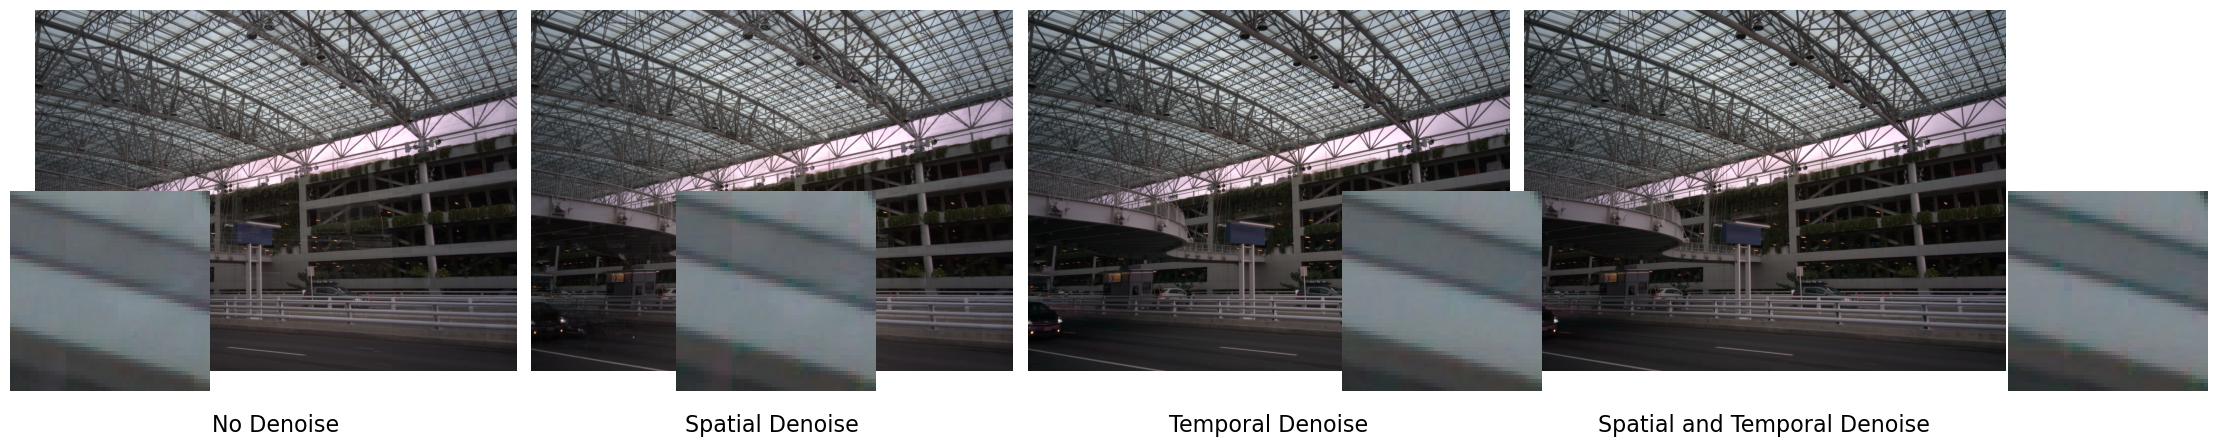

In [17]:
def create_merge_figure(images, output_path, labels):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Coordinates for the zoom-in boxes
    zoom_coords = [
        (50, 200, 100, 250),
        (50, 200, 100, 250),
        (50, 200, 100, 250),
        (50, 200, 100, 250),
    ]

    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')

        # Add the zoom-in box
        left, top, right, bottom = zoom_coords[i]
        inset_ax = fig.add_axes([-0.08 + i * 0.333, 0.1, 0.25, 0.4])
        img_crop = img[top:bottom, left:right]
        inset_ax.imshow(img_crop)
        inset_ax.axis('off')
        
        axs[i].text(0.5, -0.15, labels[i], ha='center', va='center', transform=axs[i].transAxes, fontsize=16)

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
image_lables = ['No Denoise', 'Spatial Denoise', 'Temporal Denoise', 'Spatial and Temporal Denoise']
create_merge_figure([no_denoise_image, spatial_denoise_image, temporal_denoise_image, spatial_temporal_denoise_image], './paper_illustrations/merge_image.png', image_lables)